# Run ADBench 
- Here we provide a demo for testing AD algorithms on the datasets proposed in ADBench.
- Feel free to evaluate any customized algorithm in ADBench.
- For reproducing the complete experiment results in ADBench, please run the code in the run.py file.

In [1]:
import numpy as np
from glob import glob
import pickle
import random
from tqdm import tqdm
import pandas as pd

D:\autosoftware\anconda\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# 加载训练集的pkl文件，划分训练集与验证集
训练集的label存放在pkl里面，可以通过它并区分正常片段和异常片段
注意需要输入训练集对应的路径

In [2]:
ind_pkl_files = []#存放标签为0的文件
ood_pkl_files = []#存放标签为1的文件
data_path='Train'#存放数据的路径
pkl_files = glob(data_path+'/*.pkl')
for each_path in tqdm(pkl_files):
    pic = open(each_path,'rb')
    this_pkl_file= pickle.load(pic)#下载pkl文件
    if this_pkl_file[1]['label'] == '00':
        ind_pkl_files.append(each_path)
    else:
        ood_pkl_files.append(each_path)

random.seed(0)
#排序并打乱存放车辆序号的集合
random.shuffle(ind_pkl_files)
random.shuffle(ood_pkl_files)

100%|███████████████████████████████████████████████████████████████████████████| 28389/28389 [01:37<00:00, 292.52it/s]


In [3]:
print(len(ind_pkl_files))
print(len(ood_pkl_files))

23735
4654


In [4]:
train_pkl_files=[]
for j in range(len(ind_pkl_files)//4,len(ind_pkl_files)):
#for j in range(len(ind_pkl_files)):
    train_pkl_files.append(ind_pkl_files[j])
#for i in range(len(ind_pkl_files)//4):
#    train_pkl_files.append(ind_pkl_files[i])
for j in range(len(ood_pkl_files)):
    train_pkl_files.append(ood_pkl_files[j])
print(len(train_pkl_files))
test_pkl_files=[]
#for j in range(len(ind_pkl_files)//4,len(ind_pkl_files)):
 #   test_pkl_files.append(ind_pkl_files[j])
for i in range(len(ind_pkl_files)//4):
    test_pkl_files.append(ind_pkl_files[i])
#for item in ood_pkl_files:
#    test_pkl_files.append(item)

for j in range(len(ood_pkl_files)//4):
    test_pkl_files.append(ood_pkl_files[j])
print(len(test_pkl_files))

22456
7096


# 定义加载函数，并对数据进行正则化

In [5]:
def  load_data(pkl_list,label=True):
    '''
    输入pkl的列表，进行文件加载
    label=True用来加载训练集
    label=False用来加载真正的测试集，真正的测试集无标签
    '''
    X = []
    y = []
    

    for  each_pkl in pkl_list:
        pic = open(each_pkl,'rb')
        item= pickle.load(pic)#下载pkl文件
        # 此处选取的是每个滑窗的最后一条数据，仅供参考，可以选择其他的方法，比如均值或者其他处理时序数据的网络
        # 此处选取了前7个特征，可以需求选取特征数量
        feature = item[0][:,0:7][-1]
        #feature = item[0][:,0:7][-1]
        #feature = item[0][:,0:7].mean(axis=0)
        #feature = np.append(item[0][:,0:7][-1],(item[0][:,3][-1] - item[0][:,4][-1])) #加max_single_volt - min_single_volt 一列为特征
        feature=np.append(feature,item[1]["mileage"])
        X.append(feature)
        if label:
            y.append(int(item[1]['label'][0]))
    X = np.vstack(X)
    if label:
        y = np.vstack(y)
    return X, y

In [6]:
X_train,y_train=load_data(train_pkl_files)
X_test,y_test=load_data(test_pkl_files)
_mean = np.mean(X_train, axis=0)
_std = np.std(X_train, axis=0)
X_train = (X_train - _mean) / (_std + 1e-4)
X_test = (X_test - _mean) / (_std + 1e-4)

In [7]:

from sklearn.utils import shuffle
# 进行随机打乱，这里random_state指定为固定值，则打乱结果相同
X_train,y_train = shuffle(X_train,y_train,random_state=40)


In [8]:
data_path3='Test_A'
test1_files = glob(data_path3+'/*.pkl')
X_val,_=load_data(test1_files,label=False)
_mean = np.mean(X_val, axis=0)
_std = np.std(X_val, axis=0)
X_val = (X_val - _mean) / (_std + 1e-4)

In [9]:
import sklearn.metrics
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
# import zero
import delu # the new version of zero package
import rtdl
import scipy
import platform
from myutils import Utils
utils = Utils() # utils function


class FTTransformer():
    '''
    The original code: https://yura52.github.io/rtdl/stable/index.html
    The original paper: "Revisiting Deep Learning Models for Tabular Data", NIPS 2019
    '''
    def __init__(self, seed:int, model_name:str, n_epochs=100, batch_size=64):

        self.seed = seed
        self.model_name = model_name
        self.utils = Utils()

        # device
        if model_name == 'FTTransformer':
            self.device = self.utils.get_device(gpu_specific=True)
        else:
            self.device = self.utils.get_device(gpu_specific=False)

        # Docs: https://yura52.github.io/zero/0.0.4/reference/api/zero.improve_reproducibility.html
        # zero.improve_reproducibility(seed=self.seed)
        delu.improve_reproducibility(base_seed=int(self.seed))

        # hyper-parameter
        self.n_epochs = n_epochs # default is 1000
        self.batch_size = batch_size # default is 256

    def apply_model(self, x_num, x_cat=None):
        if isinstance(self.model, rtdl.FTTransformer):
            return self.model(x_num, x_cat)
        elif isinstance(self.model, (rtdl.MLP, rtdl.ResNet)):
            assert x_cat is None
            return self.model(x_num)
        else:
            raise NotImplementedError(
                f'Looks like you are using a custom model: {type(self.model)}.'
                ' Then you have to implement this branch first.'
            )

    @torch.no_grad()
    def evaluate(self, X, y=None):
        self.model.eval()
        score = []
        # for batch in delu.iter_batches(X[part], 1024):
        for batch in delu.iter_batches(X, self.batch_size):
            score.append(self.apply_model(batch))
        score = torch.cat(score).squeeze(1).cpu().numpy()
        score = scipy.special.expit(score)

        # calculate the metric
        if y is not None:
            target = y.cpu().numpy()
            metric = self.utils.metric(y_true=target, y_score=score)
        else:
            metric = {'aucroc': None, 'aucpr': None}

        return score, metric['aucpr']

    def fit(self, X_train, y_train, ratio=None,X_test=X_test,y_test=y_test):
        # set seed
        self.utils.set_seed(self.seed)
       
        #X_train, X_test_val, y_train, y_test_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
        # training set is used as the validation set in the anomaly detection task
        X = {'train': torch.from_numpy(X_train).float().to(self.device),
             'val': torch.from_numpy(X_train).float().to(self.device)}

        y = {'train': torch.from_numpy(y_train).float().to(self.device),
             'val': torch.from_numpy(y_train).float().to(self.device)}
        
       #training set is used as the validation set in the anomaly detection task
#         X = {'train': torch.from_numpy(X_train).float().to(self.device),
#             'val': torch.from_numpy(X_test_val).float().to(self.device)}

#         y = {'train': torch.from_numpy(y_train).float().to(self.device),
#             'val': torch.from_numpy(y_test_val).float().to(self.device)}

        task_type = 'binclass'
        n_classes = None
        d_out = n_classes or 1


        if self.model_name == 'ResNet':
            self.model = rtdl.ResNet.make_baseline(
                d_in=X_train.shape[1],
                d_main=128,
                d_hidden=256,
                dropout_first=0.25,
                dropout_second=0,
                n_blocks=2,
                d_out=d_out,
            )
            lr = 0.001
            weight_decay = 0.0
        
        elif self.model_name == 'MLP':
            self.model = rtdl.MLP.make_baseline(
            d_in=X_train.shape[1],
            d_layers= [128, 256, 128],
            dropout=0.25,
            d_out=d_out,
            )
            lr = 0.001
            weight_decay = 0.0

        elif self.model_name == 'FTTransformer':
            self.model = rtdl.FTTransformer.make_default(
                n_num_features=X_train.shape[1],
                cat_cardinalities=None,
                last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
                d_out=d_out,
            )
            
        elif self.model_name == 'FTTransformer_baseline':
            self.model = rtdl.FTTransformer.make_baseline(
                n_num_features=X_train.shape[1],
                cat_cardinalities=None,
                d_token=X_train.shape[1],
                n_blocks=2,
                attention_dropout=0.2,
                ffn_d_hidden=6,
                ffn_dropout=0.2,
                residual_dropout=0.0,
                d_out=d_out,
            ) 
        else:
            raise NotImplementedError

        self.model.to(self.device)
        optimizer = (
            self.model.make_default_optimizer()
            if isinstance(self.model, rtdl.FTTransformer)
            else torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        )
        loss_fn = (
            F.binary_cross_entropy_with_logits
            if task_type == 'binclass'
            else F.cross_entropy
            if task_type == 'multiclass'
            else F.mse_loss
        )

        # Create a dataloader for batches of indices
        # Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
        train_loader = delu.data.IndexLoader(len(X['train']), self.batch_size, device=self.device)

        # Create a progress tracker for early stopping
        # Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
        progress = delu.ProgressTracker(patience=100)

        # training
        # report_frequency = len(X['train']) // self.batch_size // 5

        for epoch in range(1, self.n_epochs + 1):
            loss_tmp = []
            for iteration, batch_idx in enumerate(train_loader):
                self.model.train()
                optimizer.zero_grad()
                x_batch = X['train'][batch_idx]
                y_batch = y['train'][batch_idx]
                loss = loss_fn(self.apply_model(x_batch).squeeze(1), y_batch)
                loss_tmp.append(loss.item())
                loss.backward()
                optimizer.step()
                # if iteration % report_frequency == 0:
                #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

            loss_.append(sum(loss_tmp)/len(loss_tmp))
            _, val_metric = self.evaluate(X=X['val'], y=y['val'])
            print(f'Epoch {epoch:03d} | Validation metric: {val_metric:.4f}', end='')
            progress.update((-1 if task_type == 'regression' else 1) * val_metric)
            if progress.success:
                print(' <<< BEST VALIDATION EPOCH', end='')
            print()
            # 验证
            # output predicted anomaly score on testing set
            score = self.predict_score(X_test)
            # evaluation
            result = utils.metric(y_true=y_test, y_score=score)
            aucroc.append(result['aucroc'])
            aucpr.append(result['aucpr'])
            if progress.fail:
                break

        return self

    def predict_score(self, X):
        X = torch.from_numpy(X).float().to(self.device)
        score, _ = self.evaluate(X=X, y=None)
        return score

In [10]:
seed = 42
clf=FTTransformer(seed,"ResNet",n_epochs=532,batch_size=256)
aucroc = []
aucpr = []
loss_ = []
clf = clf.fit(X_train=X_train, y_train=y_train.squeeze(1),X_test=X_test,y_test=y_test)
import platform
y_val_scores = clf.predict_score(X_val)   #返回未知数据上的异常值 (分值越大越异常) # outlier scores
#记录文件名和对应的异常得分
predict_result={}
for i in tqdm(range(len(test1_files))):
    file=test1_files[i]
    #如果是window系统：
    if platform.system().lower() == 'windows':
        name=file.split('\\')[-1]
    #如果是linux系统
    elif platform.system().lower() == 'linux':
        name=file.split('/')[-1]
    predict_result[name]=y_val_scores[i]
predict_score=pd.DataFrame(list(predict_result.items()),columns=['file_name','score'])#列名必须为这俩个
predict_score.to_csv(f'submision.csv',index = False) #保存为比赛要求的csv文件

Epoch 001 | Validation metric: 0.8804 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation metric: 0.9405 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation metric: 0.9575 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation metric: 0.9711 <<< BEST VALIDATION EPOCH
Epoch 005 | Validation metric: 0.9709
Epoch 006 | Validation metric: 0.9792 <<< BEST VALIDATION EPOCH
Epoch 007 | Validation metric: 0.9836 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation metric: 0.9865 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation metric: 0.9855
Epoch 010 | Validation metric: 0.9902 <<< BEST VALIDATION EPOCH
Epoch 011 | Validation metric: 0.9921 <<< BEST VALIDATION EPOCH
Epoch 012 | Validation metric: 0.9911
Epoch 013 | Validation metric: 0.9902
Epoch 014 | Validation metric: 0.9931 <<< BEST VALIDATION EPOCH
Epoch 015 | Validation metric: 0.9923
Epoch 016 | Validation metric: 0.9932 <<< BEST VALIDATION EPOCH
Epoch 017 | Validation metric: 0.9950 <<< BEST VALIDATION EPOCH
Epoch 018 | Validation metric: 0.9939
Epoc

Epoch 193 | Validation metric: 0.9995
Epoch 194 | Validation metric: 0.9996 <<< BEST VALIDATION EPOCH
Epoch 195 | Validation metric: 0.9992
Epoch 196 | Validation metric: 0.9993
Epoch 197 | Validation metric: 0.9993
Epoch 198 | Validation metric: 0.9989
Epoch 199 | Validation metric: 0.9996
Epoch 200 | Validation metric: 0.9993
Epoch 201 | Validation metric: 0.9995
Epoch 202 | Validation metric: 0.9994
Epoch 203 | Validation metric: 0.9995
Epoch 204 | Validation metric: 0.9995
Epoch 205 | Validation metric: 0.9993
Epoch 206 | Validation metric: 0.9992
Epoch 207 | Validation metric: 0.9992
Epoch 208 | Validation metric: 0.9995
Epoch 209 | Validation metric: 0.9992
Epoch 210 | Validation metric: 0.9995
Epoch 211 | Validation metric: 0.9993
Epoch 212 | Validation metric: 0.9991
Epoch 213 | Validation metric: 0.9993
Epoch 214 | Validation metric: 0.9995
Epoch 215 | Validation metric: 0.9993
Epoch 216 | Validation metric: 0.9995
Epoch 217 | Validation metric: 0.9993
Epoch 218 | Validation m

Epoch 405 | Validation metric: 0.9997
Epoch 406 | Validation metric: 0.9995
Epoch 407 | Validation metric: 0.9997
Epoch 408 | Validation metric: 0.9997
Epoch 409 | Validation metric: 0.9998 <<< BEST VALIDATION EPOCH
Epoch 410 | Validation metric: 0.9998
Epoch 411 | Validation metric: 0.9997
Epoch 412 | Validation metric: 0.9998
Epoch 413 | Validation metric: 0.9996
Epoch 414 | Validation metric: 0.9997
Epoch 415 | Validation metric: 0.9998
Epoch 416 | Validation metric: 0.9998
Epoch 417 | Validation metric: 0.9998
Epoch 418 | Validation metric: 0.9997
Epoch 419 | Validation metric: 0.9997
Epoch 420 | Validation metric: 0.9998
Epoch 421 | Validation metric: 0.9997
Epoch 422 | Validation metric: 0.9996
Epoch 423 | Validation metric: 0.9998
Epoch 424 | Validation metric: 0.9993
Epoch 425 | Validation metric: 0.9998
Epoch 426 | Validation metric: 0.9997
Epoch 427 | Validation metric: 0.9996
Epoch 428 | Validation metric: 0.9996
Epoch 429 | Validation metric: 0.9992
Epoch 430 | Validation m

100%|██████████████████████████████████████████████████████████████████████████| 6234/6234 [00:00<00:00, 520997.29it/s]


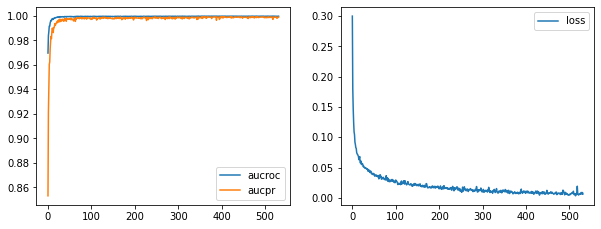

471
471


In [11]:
from matplotlib import pyplot as plt
plt.figure(figsize=((10,8)))
plt.subplot(221)
plt.plot(aucroc,label="aucroc")
plt.plot(aucpr,label="aucpr")
plt.legend()
plt.subplot(222)
plt.plot(loss_,label="loss")
plt.legend()
plt.show()
print(aucroc.index(max(aucroc)))
print(aucpr.index(max(aucpr)))

In [12]:
clf.model

ResNet(
  (first_layer): Linear(in_features=8, out_features=128, bias=True)
  (blocks): Sequential(
    (0): Block(
      (normalization): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_first): Linear(in_features=128, out_features=256, bias=True)
      (activation): ReLU()
      (dropout_first): Dropout(p=0.25, inplace=False)
      (linear_second): Linear(in_features=256, out_features=128, bias=True)
      (dropout_second): Dropout(p=0, inplace=False)
    )
    (1): Block(
      (normalization): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_first): Linear(in_features=128, out_features=256, bias=True)
      (activation): ReLU()
      (dropout_first): Dropout(p=0.25, inplace=False)
      (linear_second): Linear(in_features=256, out_features=128, bias=True)
      (dropout_second): Dropout(p=0, inplace=False)
    )
  )
  (head): Head(
    (normalization): BatchNorm1d(128, eps=1e-05, momentum=0.

In [13]:
from thop import clever_format
from thop import profile
input = torch.randn(256, 8)
flops, params =profile(clf.model, inputs=(input,))
flops, params = clever_format([flops, params], "%.3f")
print(flops)
print(params)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
34.243M
133.889K
